# Fixed-Point Precision Neural Network for MNIST dataset

This example shows how a fixed-point precision affects prediction performance of a two layer neural network trained with MNIST dataset.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import numpy as np

## MNIST dataset loading and formating

In [2]:
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Training data shape: ", x_train.shape) 
print("Test data shape", x_test.shape) 

# Flatten the images
image_size = 784 # 28*28
x_train = x_train.reshape(x_train.shape[0], image_size)
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)


## Neural Network model (KERAS sequential)

We are going to build a classical Neural Network using two dense layers of 16 units per layer, *sigmoid* activation for hidden-layers and *softmax* for output layer.

In [3]:
model = Sequential()
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,), name='layer_0'))
model.add(Dense(units=32, activation='sigmoid', name='layer_1'))
model.add(Dense(units=num_classes, activation='softmax', name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (Dense)              (None, 32)                25120     
_________________________________________________________________
layer_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


## Model compiling and training

In [4]:
N_epochs = 50
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=N_epochs, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 21us/sample - loss: 2.1347 - accuracy: 0.3806 - val_loss: 1.9654 - val_accuracy: 0.5880
Epoch 2/50
54000/54000 [==============================] - 1s 12us/sample - loss: 1.8749 - accuracy: 0.6183 - val_loss: 1.7497 - val_accuracy: 0.7025
Epoch 3/50
54000/54000 [==============================] - 1s 13us/sample - loss: 1.6682 - accuracy: 0.6982 - val_loss: 1.5351 - val_accuracy: 0.7658
Epoch 4/50
54000/54000 [==============================] - 1s 11us/sample - loss: 1.4625 - accuracy: 0.7505 - val_loss: 1.3283 - val_accuracy: 0.8028
Epoch 5/50
54000/54000 [==============================] - 1s 12us/sample - loss: 1.2747 - accuracy: 0.7839 - val_loss: 1.1425 - val_accuracy: 0.8393
Epoch 6/50
54000/54000 [==============================] - 1s 12us/sample - loss: 1.1104 - accuracy: 0.8097 - val_loss: 0.9869 - val_accuracy: 0.8567
Epoch 7/50
54000/54000 [==============================] -

Evaluate performance on *test partition* of the dataset:

In [5]:
float_loss, float_accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {float_loss:.3}')
print(f'Test accuracy: {float_accuracy:.3}')

Test loss: 0.264
Test accuracy: 0.924


Plot the training evolution vs epochs

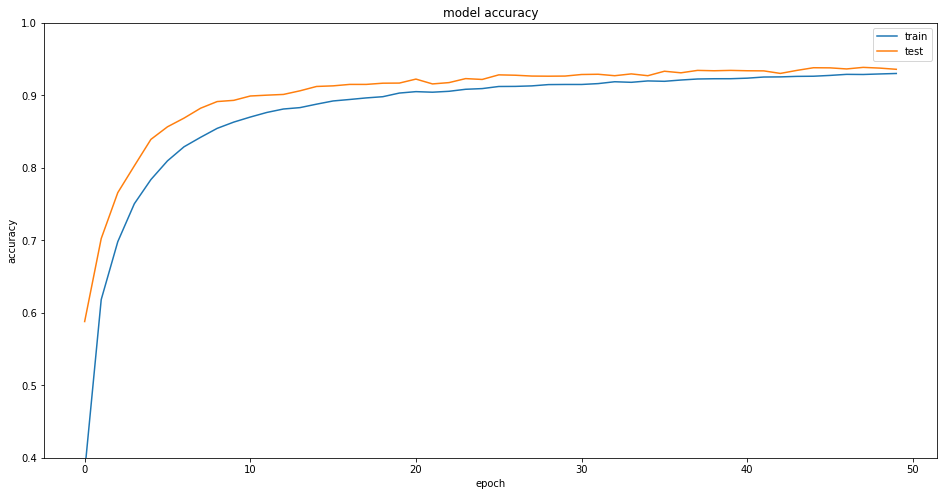

In [6]:
plt.figure(figsize=(16,8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim([0.4, 1])
plt.show()

## Convert weights and bias to Fxp (fixed-point precision)

Get the layer names of the model:

In [7]:
for layer in model.layers:
    print(layer.name)

layer_0
layer_1
output


Read the weights and bias from each layer and store that information in a dictionary:

In [8]:
w_dict = {}
for layer in model.layers:
    w_dict[layer.name] = model.get_layer(layer.name).get_weights() # [layer_x_weights, layer_x_bias] 

    # print mean and standard deviation from weights and bias
    print('{} (weights):\tmean = {}\tstd = {}'.format(layer.name, np.mean(w_dict[layer.name][0]), np.std(w_dict[layer.name][0])))
    print('{} (bias):\t\tmean = {}\tstd = {}\n'.format(layer.name, np.mean(w_dict[layer.name][1]), np.std(w_dict[layer.name][1])))

layer_0 (weights):	mean = -0.0010486405808478594	std = 0.05828613415360451
layer_0 (bias):		mean = 5.2262657845858485e-05	std = 0.0012827293248847127

layer_1 (weights):	mean = 0.004120169207453728	std = 0.35852742195129395
layer_1 (bias):		mean = 0.0014723322819918394	std = 0.06975243985652924

output (weights):	mean = 0.024269040673971176	std = 0.7088005542755127
output (bias):		mean = 2.3841858265427618e-08	std = 0.0630764588713646



## Fxp for whole network

An experiment could be choose a single fixed-point precision for whole network. In this case, a signed word of 16 bits, and 15 bits fractional has been choosen:

In [9]:
from fxpmath import Fxp

fxp_ref = Fxp(None, dtype='fxp-s16/15')

Convert all weights to fixed-point:

In [10]:
w_fxp_dict = {}

for layer in w_dict.keys():
    w_fxp_dict[layer] = [
        Fxp(w_dict[layer][0], like=fxp_ref), 
        Fxp(w_dict[layer][1], like=fxp_ref),
        ]

In [11]:
# show weights of layer_0 converted to fixed point
w_fxp_dict['layer_0'][0]

fxp-s16/15([[ 0.01678467 -0.06665039 -0.05511475 ... -0.01794434 -0.01199341
              0.04733276]
            [ 0.07794189 -0.07223511 -0.00610352 ...  0.00210571 -0.06973267
             -0.03146362]
            [-0.01721191 -0.06091309  0.02639771 ...  0.03167725  0.01989746
              0.08502197]
            ...
            [ 0.02825928  0.06658936 -0.0007019  ... -0.0032959  -0.05560303
             -0.07772827]
            [-0.05474854  0.06515503  0.02563477 ...  0.08306885  0.0697937
              0.04830933]
            [-0.00830078  0.02331543  0.03701782 ...  0.05108643  0.0057373
              0.01602173]])

**Update model weights and bias** using Fxp version of them:

In [12]:
for layer, values in w_fxp_dict.items():
    model.get_layer(layer).set_weights(values)

Evaluate Fixed-Point Model performance over *test partition*:

In [13]:
fxp_loss, fxp_accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {fxp_loss:.3}')
print(f'Test accuracy: {fxp_accuracy:.3}')

Test loss: 0.278
Test accuracy: 0.923


We can see that *loss* and *accuracy* have been slightly downgraded, but in a non-significant way.

## Evaluate performance degradation vs fractional size

We evaluate model performance modifying the size of fractional part from 1 bit to 15 bits, maintaining integer part.

In [14]:
n_frac_vals = np.arange(1, 16)
n_int = 1

fxp_loss_vals = []
fxp_acc_vals = []

for n_frac in n_frac_vals:
    fxp_ref = Fxp(None, signed=True, n_int=n_int, n_frac=n_frac)

    # convert floating point weights and bias to Fxp
    for layer, values in w_dict.items():
        
        model.get_layer(layer).set_weights([
            Fxp(values[0], like=fxp_ref), 
            Fxp(values[1], like=fxp_ref),
            ])
    
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
    print('{}:\tloss = {:.3}\tacc = {:.3}'.format(fxp_ref.dtype, loss, accuracy))

    fxp_loss_vals.append(loss)
    fxp_acc_vals.append(accuracy)

fxp-s3/1:	loss = 2.5	acc = 0.103
fxp-s4/2:	loss = 2.38	acc = 0.156
fxp-s5/3:	loss = 1.02	acc = 0.675
fxp-s6/4:	loss = 0.369	acc = 0.901
fxp-s7/5:	loss = 0.287	acc = 0.92
fxp-s8/6:	loss = 0.273	acc = 0.924
fxp-s9/7:	loss = 0.266	acc = 0.924
fxp-s10/8:	loss = 0.265	acc = 0.924
fxp-s11/9:	loss = 0.265	acc = 0.923
fxp-s12/10:	loss = 0.264	acc = 0.924
fxp-s13/11:	loss = 0.264	acc = 0.924
fxp-s14/12:	loss = 0.264	acc = 0.924
fxp-s15/13:	loss = 0.264	acc = 0.924
fxp-s16/14:	loss = 0.264	acc = 0.924
fxp-s17/15:	loss = 0.264	acc = 0.924


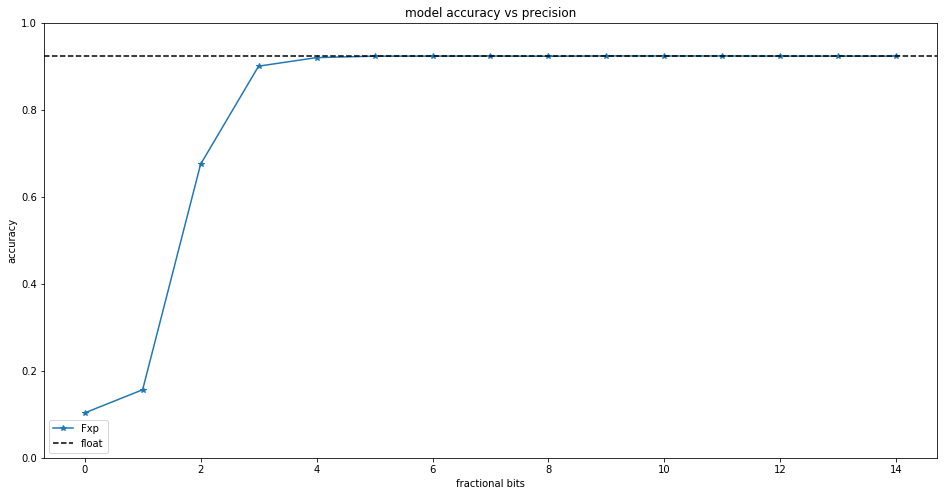

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
plt.plot(fxp_acc_vals, marker='*', label='Fxp')
ax.axhline(float_accuracy, color='k', linestyle='--', label='float')
plt.title('model accuracy vs precision')
plt.ylabel('accuracy')
plt.xlabel('fractional bits')
plt.legend()
plt.ylim([0, 1])
plt.show()

From results, it can be seen that 4 bits for fractional part is enough to get very similar performance that original model. 

An **important observation** here is that model is still performing calculation in *floating point* because kernel implementation inside Keras. An entire model in Fxp should be necessary to perform *fixed-point* calculations. Tensorflow copy values from Fxp array into *tensorflow variables* and that's the reason because Fxp could not live inside model.